In [1]:
#%pip install protobuf-compiler
#%pip install protobuf
#%pip install tensorflow_hub

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from six.moves.urllib.request import urlopen
from six import BytesIO
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time
import tempfile
from PIL import Image, ImageOps



def resize_image(image_path, new_width=256, new_height=256, display=False):
    pil_image = Image.open(image_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)

    # Save the resized image to a new temporary file
    _, resized_temp_filename = tempfile.mkstemp(suffix=".jpg")
    pil_image.save(resized_temp_filename, format="JPEG", quality=90)

    print("Image resized.")

    # Optionally display the image
    if display:
        pil_image.show()

    # Return the resized temporary file path
    return resized_temp_filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    detections = {key: value.numpy() if isinstance(value, tf.Tensor) else value for key, value in result.items()}

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    return image_with_boxes, detections

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.1):
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                            int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
        
    return image

def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [3]:
food = np.array( [["Apple",14,0.52,0.78],
                  ["Banana",439,0.89,0.91],
                  ["Bread",420,3.15,0.18],
                  ["Doughnut",566,4.34,0.31],
                  ["Egg",217,1.43,1.03],
                  ["Grape",223,0.69,0.97],
                  ["Lemon",435,0.29,0.96],
                  ["Mango",513,0.60,1.07],
                  ["Orange",481,0.63,0.90],
                  ["Peach",492,0.57,0.96],
                  ["Pear",341,0.39,1.02]])

#coin: 132
#plate: 312 

In [4]:
import cv2

def run_grabcut(image_path, detections):
    # Load the image
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    
    for box, detections['detection_class_entities'] in zip(detections['detection_boxes'], detections['detection_class_labels']):
        
        # Convert the bounding box from fractions to pixel coordinates
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

        if detections['detection_class_entities']== int(food[food_index][1]):
            # Create a mask with zeros, same size as the image
            mask = np.zeros((height, width), np.uint8)

            # Create a binary mask with foreground set to 1 inside the bounding box
            mask[ymin:ymax, xmin:xmax] = 1

            # Initialize the GrabCut algorithm
            bgd_model = np.zeros((1, 65), np.float64)
            fgd_model = np.zeros((1, 65), np.float64)

            # Run the GrabCut algorithm with the initial mask
            cv2.grabCut(image, mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

            # Create a binary mask where the foreground is True (3 and 1 are the possible states of the mask)
            mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

            # Multiply the original image with the binary mask to get the segmented image
            segmented_image = image * mask2[:, :, np.newaxis]

            # Display the original image and the segmented image
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title('Segmented Image')
            print(ymin, xmin, ymax, xmax)
            plt.show()

            return segmented_image, ymin, xmin, ymax, xmax
  

In [5]:
def coin_pixels(image_path,detections):
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    
    for box, detections['detection_class_entities'] in zip(detections['detection_boxes'], detections['detection_class_labels']):
        
        # Convert the bounding box from fractions to pixel coordinates
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

        if detections['detection_class_entities']== 132:
            
            return ymin, xmin, ymax, xmax

# SIDE IMAGE

In [7]:
image_path = ""
resized_image_path = resize_image(image_path, new_width=256, new_height=256, display=True)
downloaded_image_path = resize_image(image_path, 1280, 856, True)

Image resized.
Image resized.


Found 100 objects.
Inference time:  101.33084106445312
Font not found, using default font.


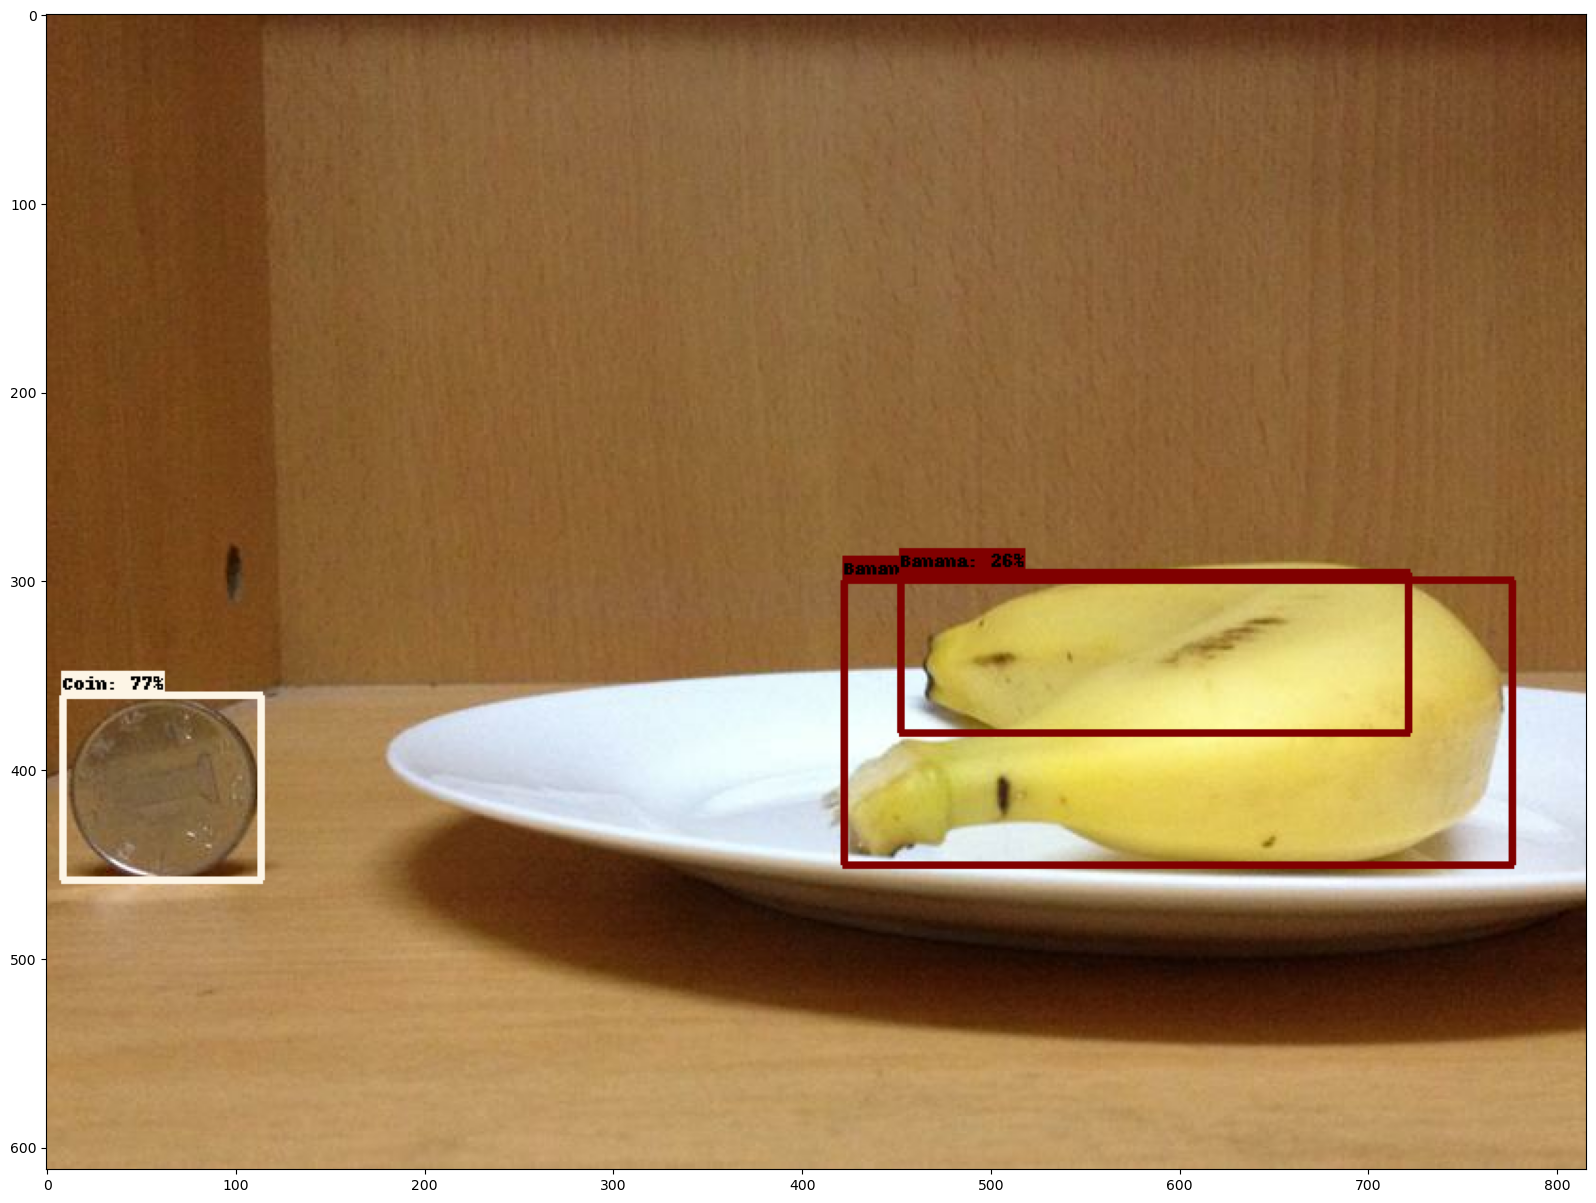

In [8]:
image_with_boxes, detections = run_detector(detector, image_path)
display_image(image_with_boxes)

In [9]:
max_score = max(detections['detection_scores'])
print(max_score)

for detections['detection_scores'],detections['detection_class_entities'] in zip(detections['detection_boxes'], detections['detection_class_labels']):
    #print(detections['detection_class_entities'])
    for i in range(len(food)):
        
        if detections['detection_class_entities'] == int(food[i][1]):
            
            food_index = i

0.840307


In [10]:
print(food[food_index][1])

439


300 422 450 777


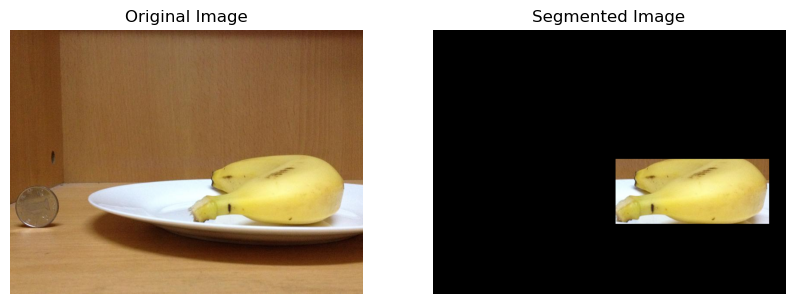

In [11]:
segmented_image_s,ymin_s, xmin_s, ymax_s, xmax_s = run_grabcut(image_path, detections)

In [12]:
ymin_cs, xmin_cs, ymax_cs, xmax_cs = coin_pixels(image_path,detections)

# TOP IMAGE

Image resized.
Found 100 objects.
Inference time:  19.134057760238647
Font not found, using default font.


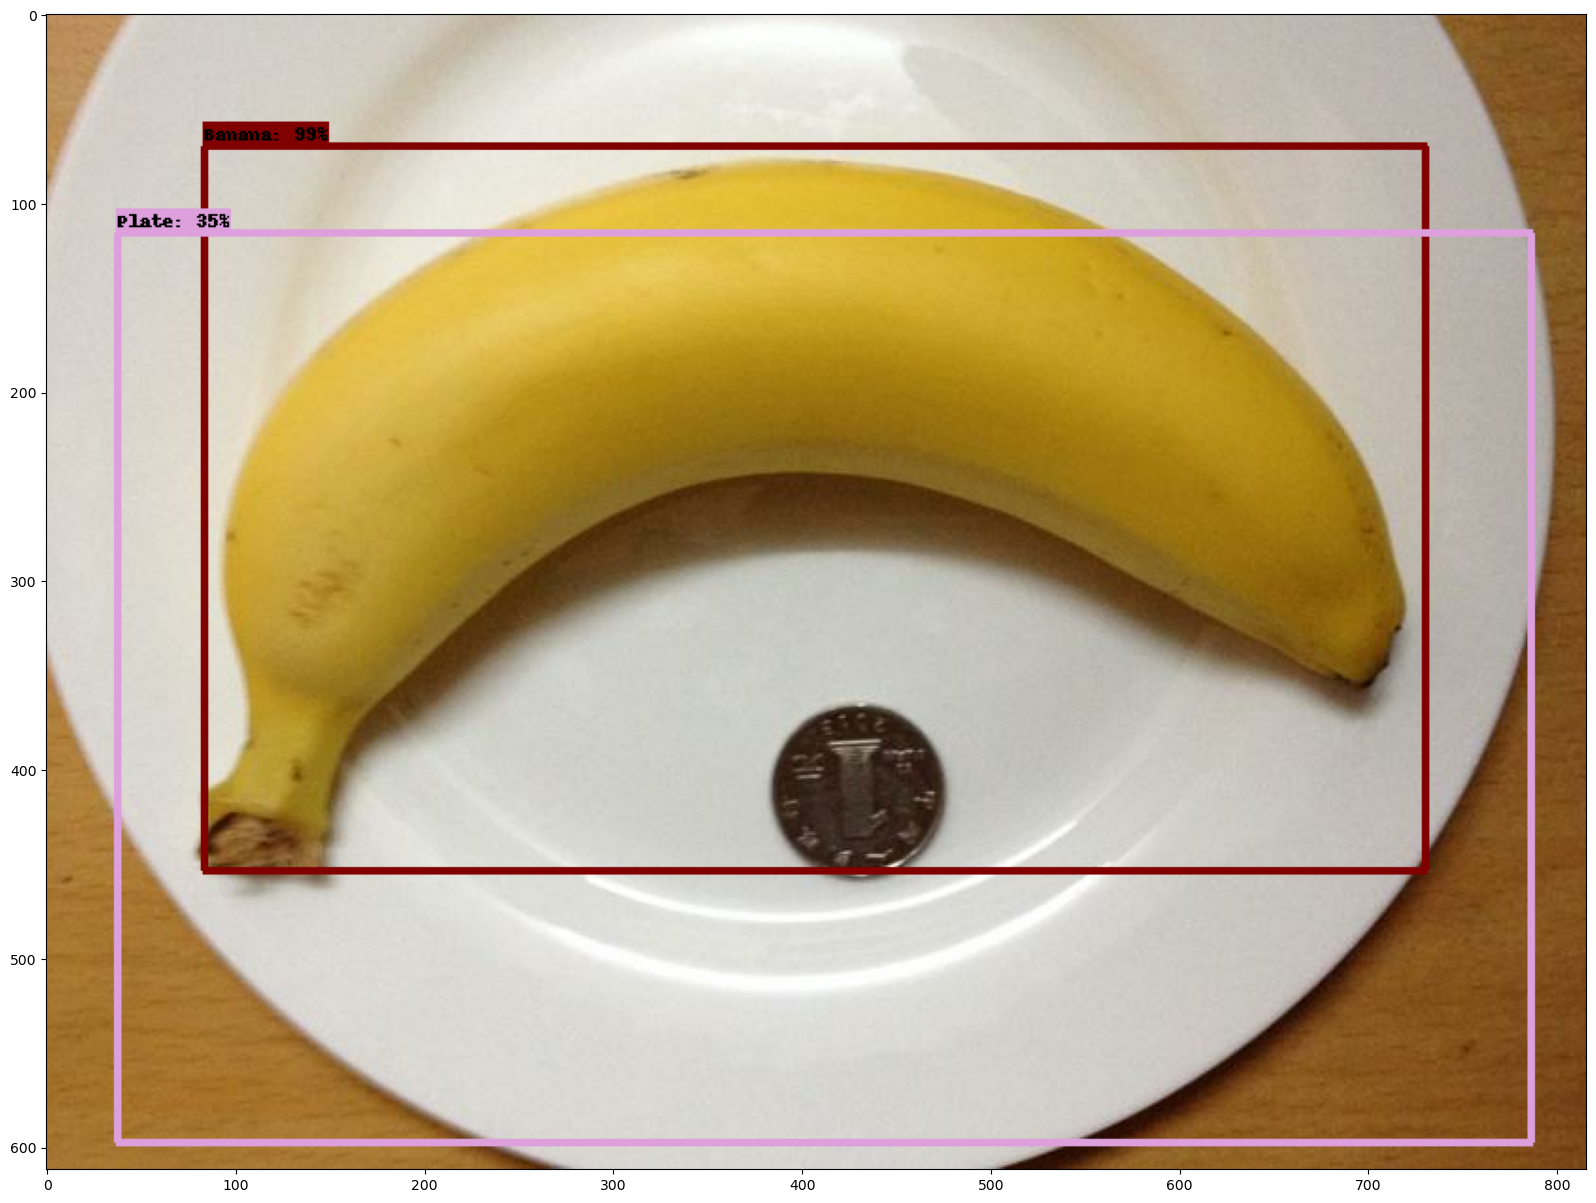

In [13]:
image_path1 = ""
downloaded_image_path = resize_image(image_path1, 1280, 856, True)
image_with_boxes, detections = run_detector(detector, image_path1)
display_image(image_with_boxes)

70 83 453 731


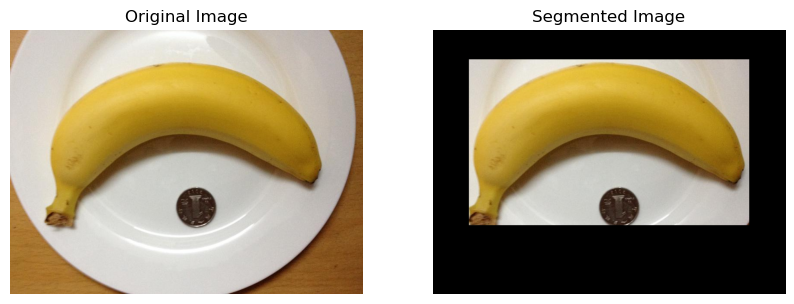

In [14]:
segmented_image_t,ymin_t, xmin_t, ymax_t, xmax_t = run_grabcut(image_path1, detections)

In [15]:
ymin_ct, xmin_ct, ymax_ct, xmax_ct = coin_pixels(image_path1,detections)

# VOLUME ESTIMATION

In [16]:
coin_diameter_mm = 25.0
coin_diameter_pixel = 94.49 

top_coin_height_mm = ((ymax_ct - ymin_ct) * coin_diameter_mm)/coin_diameter_pixel
side_coin_height_mm = ((ymax_cs - ymin_cs) * coin_diameter_mm)/coin_diameter_pixel

# Calcolo del fattore di conversione da millimetri a pixel
conversion_factor_top = top_coin_height_mm / (ymax_ct - ymin_ct)
conversion_factor_side = side_coin_height_mm / (ymax_cs - ymin_cs)
print(top_coin_height_mm)

28.045295798497197


In [17]:

# Calcolo delle dimensioni dell'area del box in millimetri utilizzando il fattore di conversione
top_view_box_width_mm = (xmax_t - xmin_t) * conversion_factor_top 
top_view_box_height_mm = (ymax_t - ymin_t) * conversion_factor_top 

side_view_box_width_mm = (xmax_s - xmin_s) * conversion_factor_side
side_view_box_height_mm = (ymax_s - ymin_s) * conversion_factor_side

volume = (top_view_box_width_mm*side_view_box_height_mm*top_view_box_height_mm)/1000
weight= volume * float(food[food_index][3])
energy = float(food[food_index][2])

estimated_calories = energy * weight

print("Estimated dimensions of the food box from the top view (length x height)", top_view_box_width_mm, "mm x", top_view_box_height_mm, "mm")
print("Estimated dimensions of the food box from the side view (length x height)", side_view_box_width_mm, "mm x", side_view_box_height_mm, "mm")
print("Estimated weight:", weight, "g")
print("Estimated volume:", volume, "cm^3")
print("Estimated calories:", estimated_calories, "calories")


Estimated dimensions of the food box from the top view (length x height) 171.44671393798285 mm x 101.33347444173987 mm
Estimated dimensions of the food box from the side view (length x height) 93.9252830987406 mm x 39.686739337496036 mm
Estimated weight: 627.4352443317654 g
Estimated volume: 689.4892794854564 cm^3
Estimated calories: 558.4173674552712 calories
